In [1]:
import numpy as np
import pandas as pd
from utils import *
import graphviz as gv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [4]:
#Example 5.2 (Bias Quantification in College Admissions - MODIFIED)
#Create College Admissions Class
class CollegeAdmissions():
    def __init__(self,args):
        np.random.seed(args['seed'])  
        self.n = args['n']
        self.p_x = args['p_x']
        self.p_z = args['p_z']
        self.p_w = args['p_w']
        self.p_y = args['p_y']
        self.confounding_xz = np.random.uniform(0, 1, self.n)
        self.effect_xw = args['effect_xw']
        self.effect_zw = args['effect_zw']
        self.effect_xy = args['effect_xy']
        self.effect_zy = args['effect_zy']
        self.effect_wy = args['effect_wy']
        self.confounder_strength_x = args['confounder_strength_x']
        self.confounder_strength_z = args['confounder_strength_z']
        
        
    def generate_data(self):
        x = np.random.binomial(1, self.p_x + self.confounder_strength_x*self.confounding_xz, self.n)
        z = np.random.binomial(1, self.p_z + self.confounder_strength_x*self.confounding_xz, self.n)
        w = np.random.binomial(1, self.p_w + self.effect_xw*x + self.effect_zw*z, self.n)
        y = np.random.binomial(1, self.p_y + self.effect_xy*x + self.effect_zy*z + self.effect_wy*w, self.n)
        return pd.DataFrame({'X': x, 'Z': z, 'W': w, 'Y': y})
    
    def generate_dag(self):
        #whenever effect_source_target is not 0, we add directed edge from source to target
        dag = gv.Digraph()
        dag.node('X')
        dag.node('Z')
        dag.node('W')
        dag.node('Y')
        if self.effect_xw != 0:
            dag.edge('X', 'W')
        if self.effect_zw != 0:
            dag.edge('Z', 'W')
        if self.effect_xy != 0:
            dag.edge('X', 'Y')
        if self.effect_zy != 0:
            dag.edge('Z', 'Y')
        if self.effect_wy != 0:
            dag.edge('W', 'Y')
        
        if self.confounder_strength_x != 0 and self.confounder_strength_z != 0:
            #add dashed, bidirectional edge between X and Z
            dag.edge('X', 'Z', style='dashed', dir='both')
        return dag
    
    def compute_tv_measure(observational_data):
        data = observational_data
        
        #####Population Level#######################
        #TV defined as P(Y|x=1) - P(Y|x=0)

        #check if column name is 'Y' or 'Y_hat'
        if 'Y_hat' in data.columns:

            tv = data[data['X'] == 1]['Y_hat'].mean() - data[data['X'] == 0]['Y_hat'].mean()
            return np.round(tv,4)
        
        else:
            tv = data[data['X'] == 1]['Y'].mean() - data[data['X'] == 0]['Y'].mean()
            return np.round(tv,4)
        
    
    def decompose_tv_x_specific(observational_data):
        
        #Assuming Binary Variables
        unique_values = [0,1] 
        data = observational_data
        #total number of observations 
        total_samples = data.shape[0]
        #filtered data where X=1
        filter_1 = data[data['X'] == 1]
        #number of observations where X=1
        samples_x1 = filter_1.shape[0]
        #filtered data where X=0
        filter_0 = data[data['X'] == 0]
        #number of observations where X=0
        samples_x0 = filter_0.shape[0]

        filtered1 = data[(data['X']==1)]
        samples1 = filtered1.shape[0]
        filtered0 = data[(data['X']==0)]
        samples0 = filtered0.shape[0]
        unique_values = [0,1]
        iterations_de = []
        interations_ie = []
        iterations_se = []


        for z in unique_values:
            for w in unique_values:
                #P(z|X=0)
                p_z_x0 = filtered0[(filtered0['Z'] == z)].shape[0]/samples0
                #P(z|X=1)
                p_z_x1 = filtered1[(filtered1['Z'] == z)].shape[0]/samples1
                #P(w|X=0,z)
                p_w_x0_z = filtered0[(filtered0['W']== w) &(filtered0['Z'] == z)].shape[0]/filtered0[(filtered0['Z'] == z)].shape[0]
                #P(w|X=1,z)
                p_w_x1_z = filtered1[(filtered1['W']== w) &(filtered1['Z'] == z)].shape[0]/filtered1[(filtered1['Z'] == z)].shape[0]
                #P(Y|X=0,z,w)
                p_y_x0_z_w = filtered0[(filtered0['W']== w) &(filtered0['Z'] == z)]['Y'].mean()
                #P(Y|X=1,z,w)
                p_y_x1_z_w = filtered1[(filtered1['W']== w) &(filtered1['Z'] == z)]['Y'].mean()
                #P(Y|X=1,z)
                p_y_x1_z = filtered1[(filtered1['Z'] == z)]['Y'].mean()


                intermediate_de = (p_y_x1_z_w-p_y_x0_z_w)*p_w_x0_z*p_z_x0
                iterations_de.append(intermediate_de)

                intermediate_ie = p_y_x1_z_w*(p_w_x0_z-p_w_x1_z)*p_z_x0
                interations_ie.append(intermediate_ie)

                intermediate_se = p_y_x1_z*(p_z_x0-p_z_x1)
                iterations_se.append(intermediate_se)


        x_de = np.sum(iterations_de)
        x_ie = np.sum(interations_ie)
        x_se = np.sum(iterations_se)
        x_tv = x_de - x_ie - x_se

        return x_tv,x_de,x_ie,x_se

    def proportions(scm):
        #we group by x=0 and x=1 and calculate the proportion of y, z, w 
        #output format: table with columns z,w,y and rows 0 and 1, where 0 and 1 represent the individual proportions z=0, w=0, y=0 and z=1, w=1, y=1
        list_proportions = []
        for x in [0,1]:
            #filter data by x
            data = scm[scm['X'] == x]
            #calculate proportions
            z0 = data[data['Z'] == 0].shape[0]/data.shape[0]
            z1 = data[data['Z'] == 1].shape[0]/data.shape[0]
            w0 = data[data['W'] == 0].shape[0]/data.shape[0]
            w1 = data[data['W'] == 1].shape[0]/data.shape[0]
            y0 = data[data['Y'] == 0].shape[0]/data.shape[0]
            y1 = data[data['Y'] == 1].shape[0]/data.shape[0]
            #store data in table
            table_proportions = pd.DataFrame({'Z': [z0,z1], 'W': [w0,w1], 'Y': [y0,y1]})
            #round all values to 4 decimal places
            table_proportions = table_proportions.round(4)
            list_proportions.append(table_proportions)
        return list_proportions
    
    
  


College Admissions 1 Data:
    X  Z  W  Y
0  0  1  0  1
1  0  0  0  0
2  0  1  0  0
3  1  0  0  0
4  0  0  0  1


Total Variation:
 26.75%


Proportions for X=0:
         Z       W       Y
0  0.4474  0.7435  0.7551
1  0.5526  0.2565  0.2449


Proportions for X=1:
         Z       W       Y
0  0.4467  0.5455  0.4876
1  0.5533  0.4545  0.5124


Corresponding DAG:



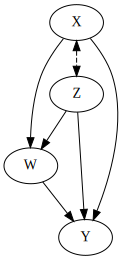

In [3]:
#Create dictionary of arguments
args = {
    #number of samples
    'n': 50000,
    #base probabilities
    'p_x': 0.5,
    'p_z': 0.5,
    'p_w': 0.2,
    'p_y': 0.1,
    #effects between variables
    'effect_xw': 0.2,
    'effect_zw': 0.1,
    'effect_xy': 0.2,
    'effect_zy': 0.1,
    'effect_wy': 0.35,
    #confounder strength
    'confounder_strength_x': 0.1,
    'confounder_strength_z': 0.1,
    #misc. 
    'seed': 36
    
}


college_admisions_1 = CollegeAdmissions(args)
scm_college_admissions_1 = college_admisions_1.generate_data()
print(f"College Admissions 1 Data:\n {scm_college_admissions_1.head()}\n\n")
print(f"Total Variation:\n {100*(CollegeAdmissions.compute_tv_measure(scm_college_admissions_1))}%\n\n")
print(f"Proportions for X=0:\n {CollegeAdmissions.proportions(scm_college_admissions_1)[0]}\n\n")
print(f"Proportions for X=1:\n {CollegeAdmissions.proportions(scm_college_admissions_1)[1]}\n\n")
print(f"Corresponding DAG:\n")
college_admisions_1.generate_dag()

Now, we want to fit logistic regression

In [4]:
class LogisticRegression_scratch():
    def __init__(self, learning_rate=0.001, n_iters=1000):
        np.random.seed(36) 
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        self.losses = []
         
    #Sigmoid method
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def compute_loss(self, y_true, y_pred):
        # binary cross entropy
        epsilon = 1e-9
        y1 = y_true * np.log(y_pred + epsilon)
        y2 = (1-y_true) * np.log(1 - y_pred + epsilon)
        return -np.mean(y1 + y2)
    
    def compute_loss_with_penalty(self, y_true, y_pred, data):
        # binary cross entropy
        epsilon = 1e-9
        y1 = y_true * np.log(y_pred + epsilon)
        y2 = (1-y_true) * np.log(1 - y_pred + epsilon)
        regularizing_strength = [0.5,0.5,0.5]
        

        return -np.mean(y1 + y2)
    

    def feed_forward(self,X):
        z = np.dot(X, self.weights) + self.bias
        A = self._sigmoid(z)
        return A

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # init parameters
        self.weights = np.zeros(n_features)
        self.bias = 0

        # gradient descent
        for _ in range(self.n_iters):
            A = self.feed_forward(X)
            self.losses.append(self.compute_loss(y,A))
            dz = A - y # derivative of sigmoid and bce X.T*(A-y)
            # compute gradients
            dw = (1 / n_samples) * np.dot(X.T, dz)
            db = (1 / n_samples) * np.sum(dz)
            # update parameters
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
            
    def predict(self, X):
        threshold = 0.5
        y_hat = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(y_hat)
        y_predicted_cls = [1 if i > threshold else 0 for i in y_predicted]
        
        return np.array(y_predicted_cls)

In [5]:
#Want to achieve same results as using sklearn.linear_model.LogisticRegression
##Fit and predict using sklearn
features = scm_college_admissions_1[['W','Z']]
#encode features as dummy variables
features = pd.get_dummies(features, columns=['W','Z'], drop_first=True)
target = scm_college_admissions_1['Y']
#split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.4, random_state=36)

#fit model
model_sklearn = LogisticRegression(random_state=36, max_iter=1000, penalty=None)
model_sklearn.fit(X_train, y_train)
#predict
y_pred_sklearn = model_sklearn.predict(X_test)
#evaluate accuracy
accuracy_sklearn = np.mean(y_pred_sklearn == y_test)
print(f"Accuracy using sklearn: {accuracy_sklearn}\n\n")

x__train_indices = X_train.index
X_train_data = scm_college_admissions_1.iloc[x__train_indices].drop('Y',axis="columns")



Accuracy using sklearn: 0.71435




In [7]:
#Initialize our Logistic Regression model
model = LogisticRegression_scratch(learning_rate=0.5, n_iters=1000)
#fit model
model.fit(X_train, y_train)
#predict Y based on W and Z
y_pred = model.predict(X_test)
#evaluate accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy using own model: {accuracy}\n\n")
#evaluate tv measure for predicted values with respect to X=0 and X=1
indices_ytest = y_test.index
#subset scm_college_admissions_1 by indices_ytest
scm_college_admissions_1_subset = scm_college_admissions_1.loc[indices_ytest].drop('Y',axis='columns')
scm_college_admissions_1_subset["Y"] = y_pred

tv_decomposed_population_level, nde, nie, exp_se_x1 = CollegeAdmissions.decompose_tv_x_specific(scm_college_admissions_1)
print(f"Total Variation in Data:\n {100*np.round(tv_decomposed_population_level,2)}%\n")
print(f"Decomposing TV in data into its individual effects - population level")
print(f"Natural Direct Effect:\n {np.round(nde,4)}")
print(f"Natural Indirect Effect:\n {np.round(nie,4)}")
print(f"Experimental Spurious Effect for X=1:\n {np.round(exp_se_x1,4)}")


tv_decomposed_population_level, nde, nie, exp_se_x1 = CollegeAdmissions.decompose_tv_x_specific(scm_college_admissions_1_subset)
print(f"Total Variation of Logistic Regression from Scratch:\n {100*np.round(tv_decomposed_population_level,3)}%\n")
print(f"Decomposing TV in predictions into its individual effects - population level")
print(f"Natural Direct Effect:\n {np.round(nde,4)}")
print(f"Natural Indirect Effect:\n {np.round(nie,4)}")
print(f"Experimental Spurious Effect for X=1:\n {np.round(exp_se_x1,4)}")


Accuracy using own model: 0.71435


Total Variation in Data:
 27.0%

Decomposing TV in data into its individual effects - population level
Natural Direct Effect:
 0.1982
Natural Indirect Effect:
 -0.0692
Experimental Spurious Effect for X=1:
 -0.0002
Total Variation of Logistic Regression from Scratch:
 19.400000000000002%

Decomposing TV in predictions into its individual effects - population level
Natural Direct Effect:
 0.0
Natural Indirect Effect:
 -0.1934
Experimental Spurious Effect for X=1:
 -0.0004


In [12]:
class LogisticRegression_scratch_penalty():
    def __init__(self, learning_rate=0.001, n_iters=1000):
        np.random.seed(36) 
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        self.losses = []
        self.threshold = 0.5
    #Sigmoid method
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def compute_loss(self, y_true, y_pred):
        # binary cross entropy
        epsilon = 1e-9
        y1 = y_true * np.log(y_pred + epsilon)
        y2 = (1-y_true) * np.log(1 - y_pred + epsilon)
        return -np.mean(y1 + y2)
    
    
    def feed_forward(self,X):
        z = np.dot(X, self.weights) + self.bias
        A = self._sigmoid(z)
        return A

    def fit(self, X, y, X_train_data):
        n_samples, n_features = X.shape

        # init parameters
        self.weights = np.zeros(n_features)
        self.bias = 0

        # gradient descent
        for _ in range(self.n_iters):
            A = self.feed_forward(X)
            intermediate_cls = [1 if i > self.threshold else 0 for i in A]
            intermediate_table = X_train_data
            intermediate_table['Y'] = intermediate_cls
            intermediate_x_tv,intermediate_x_de,intermediate_x_ie,intermediate_x_se = CollegeAdmissions.decompose_tv_x_specific(intermediate_table)
            self.losses.append(self.compute_loss(y,A))
            dz = A - y # derivative of sigmoid and bce X.T*(A-y)
            # compute gradients
            dw = (1 / n_samples) * np.dot(X.T, dz) 
            db = (1 / n_samples) * np.sum(dz)
            # update parameters
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
            
    def predict(self, X):
        threshold = self.threshold
        y_hat = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(y_hat)
        y_predicted_cls = [1 if i > threshold else 0 for i in y_predicted]
        
        return np.array(y_predicted_cls)

: 

In [11]:
#Initialize our Logistic Regression model
model = LogisticRegression_scratch_penalty(learning_rate=0.5, n_iters=1000)
#fit model
model.fit(X_train, y_train,X_train_data)
#predict Y based on W and Z
y_pred = model.predict(X_test)
#evaluate accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy using own model: {accuracy}\n\n")

y_pred

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.10838064998703337
0.0
0.0
0.0
0.09250720286275554
0.0
0.0
0.09250720286275554
0.0
0.09250720286275554
0.0
0.09250720286275554
0.0
0.09250720286275554
0.0
0.09250720286275554
0.09250720286275554
0.0
0.09250720286275554
0.09250720286275554
0.0
0.09250720286275554
0.09250720286275554
0.09250720286275554
0.0
0.09250720286275554
0.09250720286275554
0.09250720286275554
0.09250720286275554
0.09250720286275554
0.0
0.09250720286275554
0.09250720286275554
0.09250720286275554
0.09250720286275554
0.09250720286275554
0.09250720286275554
0.09250720286275554
0.09250720286275554
0.09250720286275554
0.09250720286275554
0.09250720286275554
0.09250720286275554
0.09250720286275554
0.09250720286275554
0.09250720286275554
0.09250720286275554
0.09250720286275554
0.09250720286275554
0.09250720286275554
0.09250720286275554
0.09250720286275554
0.09250720286275554
0.09250720286275554
0.09250720286275554
0.09250720286275554
0.09250720286275554
0.09

array([1, 0, 1, ..., 0, 0, 1])

In [47]:
args1 = {
    #number of samples
    'n': 50000,
    #base probabilities
    'p_x': 0.9,
    'p_z': 0.5,
    'p_w': 0.2,
    'p_y': 0.1,
    #effects between variables
    'effect_xw': 0.2,
    'effect_zw': 0.1,
    'effect_xy': 0.2,
    'effect_zy': 0.1,
    'effect_wy': 0.35,
    #confounder strength
    'confounder_strength_x': 0.1,
    'confounder_strength_z': 0.1,
    #misc. 
    'seed': 36
    
}

args2 = {
    #number of samples
    'n': 50000,
    #base probabilities
    'p_x': 0.9,
    'p_z': 0.1,
    'p_w': 0.2,
    'p_y': 0.1,
    #effects between variables
    'effect_xw': 0.2,
    'effect_zw': 0.1,
    'effect_xy': 0.2,
    'effect_zy': 0.1,
    'effect_wy': 0.35,
    #confounder strength
    'confounder_strength_x': 0.1,
    'confounder_strength_z': 0.1,
    #misc. 
    'seed': 36
    
}


college_admisions_1 = CollegeAdmissions(args1)
scm_college_admissions_1 = college_admisions_1.generate_data()

college_admisions_2 = CollegeAdmissions(args2)
scm_college_admissions_2 = college_admisions_2.generate_data()




In [48]:
mean1 = scm_college_admissions_1["X"].mean()
mean2 = scm_college_admissions_2["X"].mean()
'''
print(f"For Environment 1:\n where the mean X is: {mean1}\n")

print(f"Proportions for X=0:\n {CollegeAdmissions.proportions(scm_college_admissions_1)[0]}\n\n")
print(f"Proportions for X=1:\n {CollegeAdmissions.proportions(scm_college_admissions_1)[1]}\n\n")


print(f"For Environment 2:\n where the mean X is: {mean2}\n")
print(f"Proportions for X=0:\n {CollegeAdmissions.proportions(scm_college_admissions_2)[0]}\n\n")
print(f"Proportions for X=1:\n {CollegeAdmissions.proportions(scm_college_admissions_2)[1]}\n\n")

'''
x_tv1,x_de1,x_ie1,x_se1 = CollegeAdmissions.decompose_tv_x_specific(scm_college_admissions_1)

x_tv2,x_de2,x_ie2,x_se2 = CollegeAdmissions.decompose_tv_x_specific(scm_college_admissions_2)



print(f"TV Environment 1: {x_tv1} vs TV Environment 2: {x_tv2}\n")
print(f"x-DE Environment 1: {x_de1} vs x-DE Environment 2: {x_de2}\n")
print(f"x-IE Environment 1: {x_ie1} vs x-DE Environment 2: {x_ie2}\n")
print(f"x-SE Environment 1: {x_se1} vs x-SE Environment 2: {x_se2}\n")


TV Environment 1: 0.2662145868562465 vs TV Environment 2: 0.27118126405584014

x-DE Environment 1: 0.18490585217507208 vs x-DE Environment 2: 0.19256351672733138

x-IE Environment 1: -0.07203566024432805 vs x-DE Environment 2: -0.07480683938265034

x-SE Environment 1: -0.009273074436846381 vs x-SE Environment 2: -0.0038109079458584078



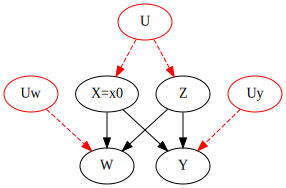

In [41]:
dag = gv.Digraph()
dag.node('X=x0')
dag.node('Z')
#dag.node('Zx0')
#dag.node('Zx1w')
dag.node('W')
#dag.node('Wx0')

dag.node('Y')
#dag.node('Yx0')
#dag.node('Yx1w')

dag.node("Uy",color='red')
dag.node("U",color='red')
dag.node("Uw",color='red')


dag.edge('U', 'Z',style='dashed', color='red')
#dag.edge('U', 'Zx0',style='dashed', color='red')
#dag.edge('U', 'Zx1w',style='dashed', color='red')

dag.edge('U', 'X=x0',style='dashed', color='red')

dag.edge('Uw', 'W',style='dashed', color='red')
#dag.edge('Uw', 'Wx0',style='dashed', color='red')

dag.edge('Uy', 'Y',style='dashed', color='red')
#dag.edge('Uy', 'Yx0',style='dashed', color='red')
#dag.edge('Uy', 'Yx1w',style='dashed', color='red')

dag.edge('X=x0', 'W')
dag.edge('X=x0', 'Y')

dag.edge('Z', 'W')
dag.edge('Z', 'Y')
#dag.edge('Z', 'Wx0')
#dag.edge('Z', 'Yx0')
#dag.edge('Z', 'Yx1w')

#dag.edge('Wx0', 'Y')
#dag.edge('Wx0', 'Yx0')


#save the graph
dag.render('sfm_wrong', format='png', view=False)
dag



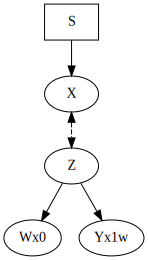

: 

In [2]:
dag = gv.Digraph()
dag.node("S",shape="box")
dag.node('X')
dag.node('Z')
#dag.node('Zx0')
#dag.node('Zx1w')
#dag.node('W')
dag.node('Wx0')

#dag.node('Y')
#dag.node('Yx0')
dag.node('Yx1w')

#dag.node("Uy",color='red')
#dag.node("U",color='red')
#dag.node("Uw",color='red')


dag.edge('S', 'X', color='black')
dag.edge('X', 'Z',style='dashed', color='black',dir='both')
dag.edge('Z', 'Wx0',color='black')
dag.edge('Z', 'Yx1w',color='black')
#save the graph
#dag.render('sfm_wrong', format='png', view=False)
dag
